# Term Deposit Sale

### Using the data collected from existing customers, build a model that will help the marketing team identify potential customers who are relatively more likely to subscribe term deposit and thus increase their hit ratio.
### The historical data for this project is available in file 
### https://archive.ics.uci.edu/ml/datasets/Bank+Marketing 

# Import modules, load the data, have a quick look

In [257]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns
import pandas_profiling

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split # to split data into training and testing sets

from sklearn import metrics
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
from sklearn import preprocessing
from scipy import stats

plt.style.use('ggplot')
pd.options.display.float_format = '{:,.2f}'.format
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')


In [258]:
df = pd.read_csv('bank-full.csv')

In [259]:
df.shape

(45211, 17)

In [260]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [261]:
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


In [262]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  Target     45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 4.1+ MB


In [263]:
df.isnull().sum().sum()

0

In [264]:
df.nunique()

age            77
job            12
marital         3
education       4
default         2
balance      7168
housing         2
loan            2
contact         3
day            31
month          12
duration     1573
campaign       48
pdays         559
previous       41
poutcome        4
Target          2
dtype: int64

In [265]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,"45,211.00",40.94,10.62,18.00,33.00,39.00,48.00,95.00
balance,"45,211.00","1,362.27","3,044.77","-8,019.00",72.00,448.00,"1,428.00","102,127.00"
day,"45,211.00",15.81,8.32,1.00,8.00,16.00,21.00,31.00
duration,"45,211.00",258.16,257.53,0.00,103.00,180.00,319.00,"4,918.00"
campaign,"45,211.00",2.76,3.10,1.00,1.00,2.00,3.00,63.00
pdays,"45,211.00",40.20,100.13,-1.00,-1.00,-1.00,-1.00,871.00
previous,"45,211.00",0.58,2.30,0.00,0.00,0.00,0.00,275.00


# Univariate Analysis

### Variable Types
### Number (7) - age, balance (in account, includes -ves and 0's), day (last contact - day of the month), duration (last contact - duration in secs), campaign (number of contacts performed during this campaign and for this client), pdays (no of days since last contact for previous campaign), previous (number of contacts performed before this campaign)
###  Categorical (6) - job (type, includes "unknown"), marital, education (includes "unknown"),  contact (type, includes unknown), month (last contact - month of the year), poutcome (outcome of previous campaign, includes "unknown")
### Boolean (4) - default (credit), housing (loan), loan (personal), target (output var)


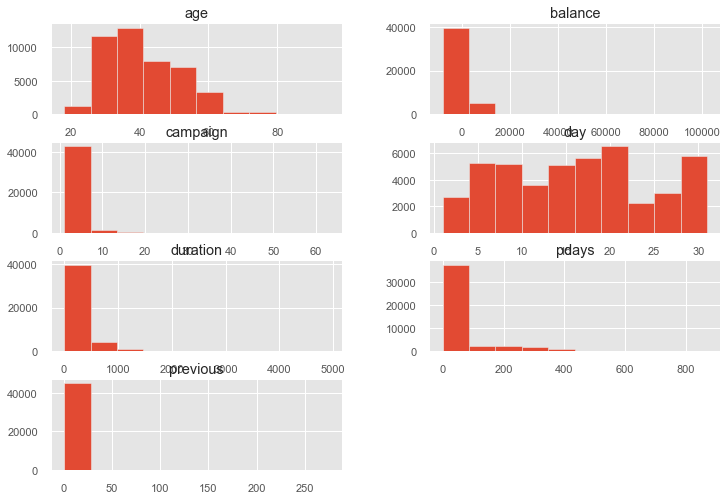

In [266]:
columns = list(df)[0:-1] # Excluding Outcome column  
df[columns].hist(stacked=False, bins=10, figsize=(12,30), layout=(14,2)); 

In [267]:
df.corr()

,age,balance,day,duration,campaign,pdays,previous
age,1.00,0.10,-0.01,-0.00,0.00,-0.02,0.00
balance,0.10,1.00,0.00,0.02,-0.01,0.00,0.02
day,-0.01,0.00,1.00,-0.03,0.16,-0.09,-0.05
duration,-0.00,0.02,-0.03,1.00,-0.08,-0.00,0.00
campaign,0.00,-0.01,0.16,-0.08,1.00,-0.09,-0.03
pdays,-0.02,0.00,-0.09,-0.00,-0.09,1.00,0.45
previous,0.00,0.02,-0.05,0.00,-0.03,0.45,1.00


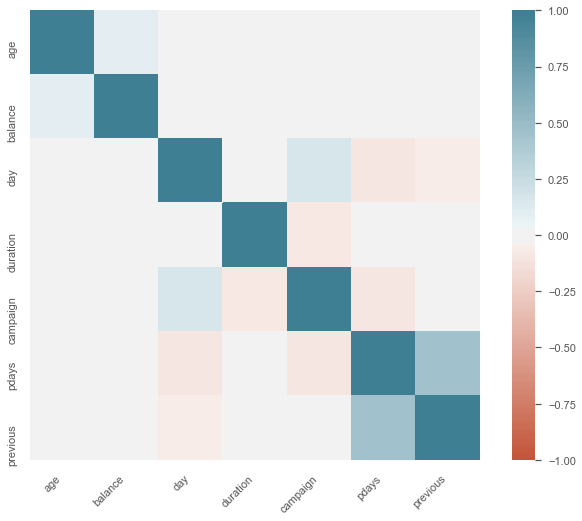

In [268]:
ax = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Calculate client subscription ratio of yes/no for term deposit

In [269]:
df['poutcome'].value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

In [270]:
n_success = len(df.loc[df['poutcome'] == 'success'])
n_total = df['poutcome'].count()
print("Number of yes: {0} ({1:2.2f}%)".format(n_success, (n_success / (n_total)) * 100 ))

Number of yes: 1511 (3.34%)


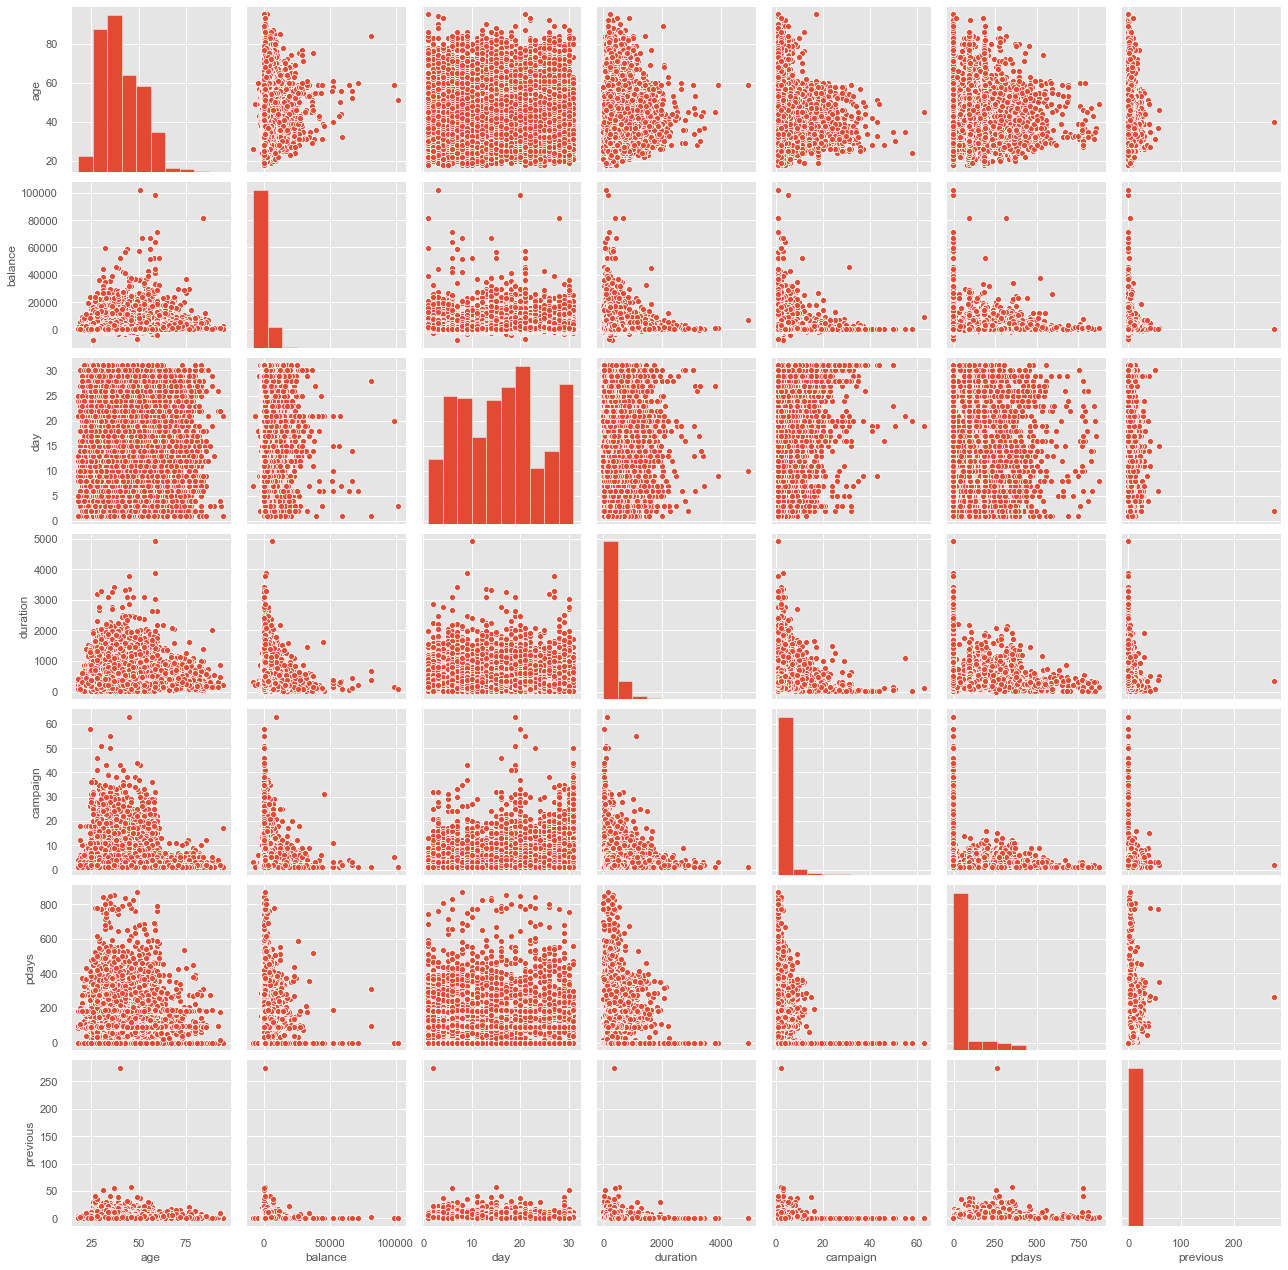

In [271]:
sns.pairplot(df)
plt.show()

### poutcome, contact categorical variables have "unknown"
### we leave them as is, though poutcome has higher count 
### we convert categorical and booleans to category type
### here instead of when we prepare the model

In [272]:
df_model = df.copy()
df_model['job'] = df_model['job'].astype('category').cat.codes
df_model['marital'] = df_model['marital'].astype('category').cat.codes
df_model['education'] = df_model['education'].astype('category').cat.codes
df_model['contact'] = df_model['contact'].astype('category').cat.codes
df_model['month'] = df_model['month'].astype('category').cat.codes
df_model['poutcome'] = df_model['poutcome'].astype('category').cat.codes
df_model['default'] = df_model['default'].astype('category').cat.codes
df_model['loan'] = df_model['loan'].astype('category').cat.codes
df_model['housing'] = df_model['housing'].astype('category').cat.codes

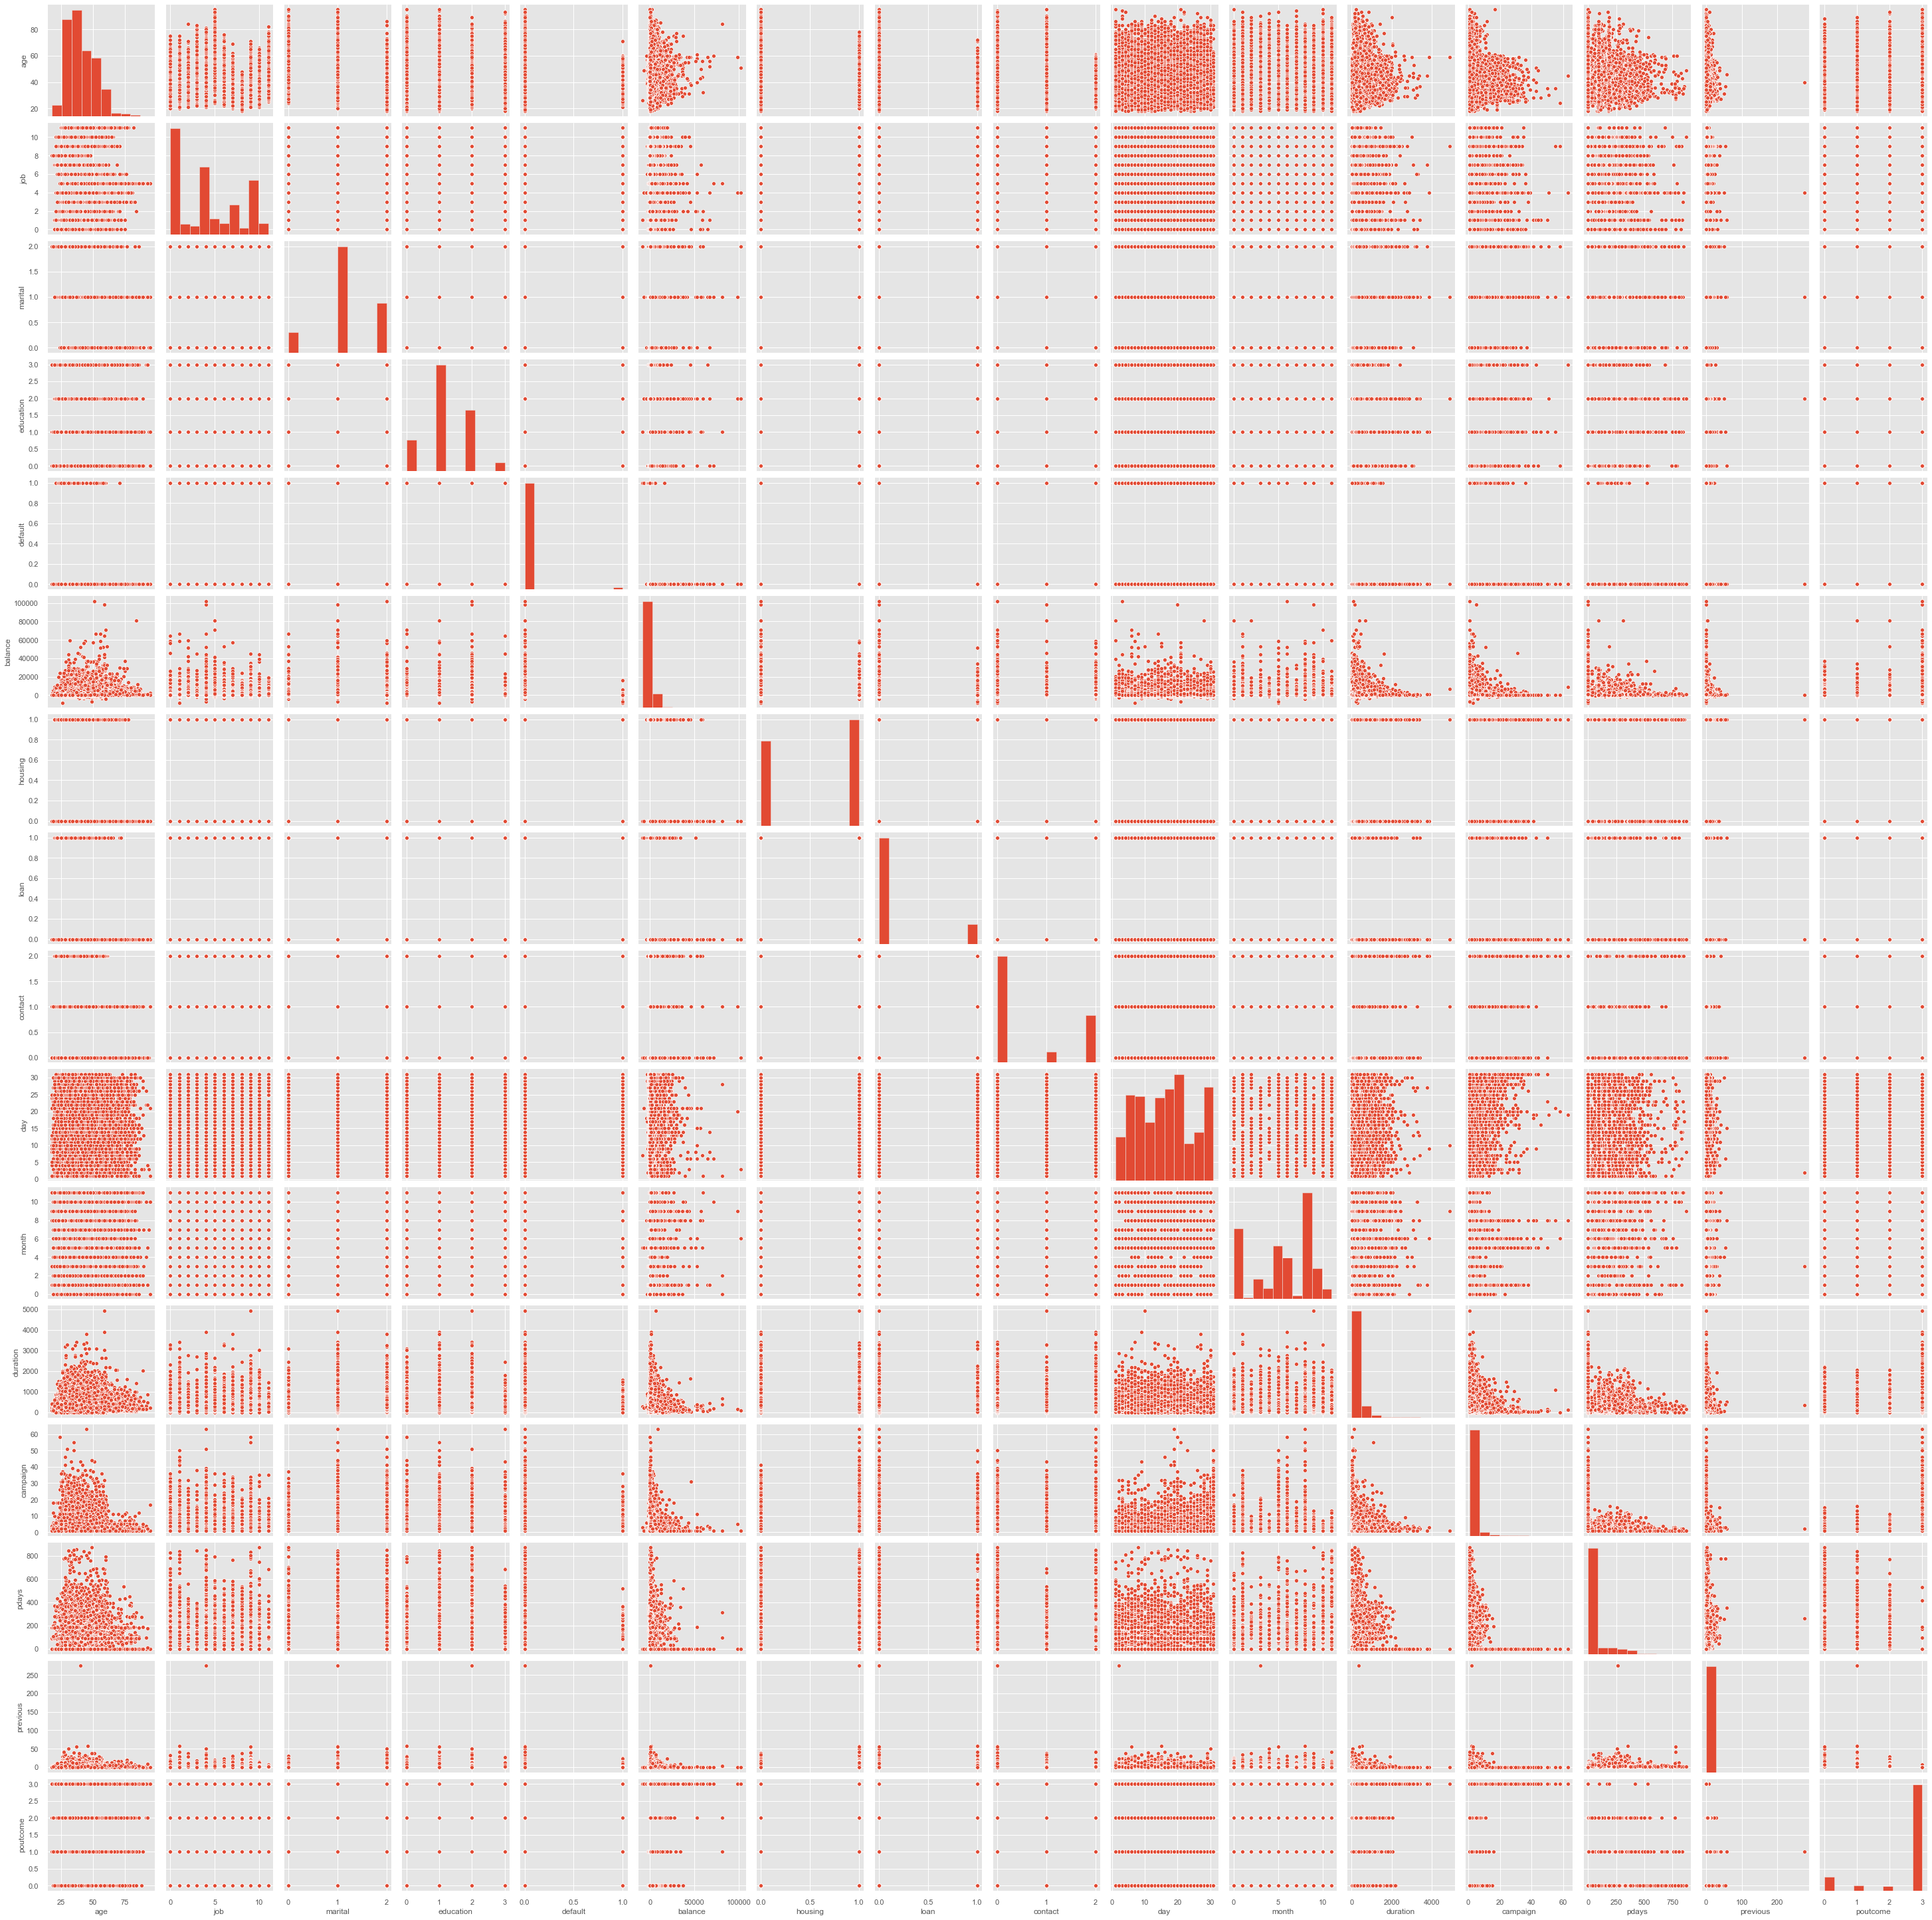

In [273]:
sns.pairplot(df_model)
plt.show()

## Summary - Univariate
### no null values
### age, min = 18, mean = 41, max = 95
### right skewness in some continous variables
### significant skewness in balance, mean = 136 std = 3,045, median = 448
### client subscription ratio of yes/no for term deposit is 3.34/96.66 % (needs to target campaign to improve subscription)
### except converting categorical variables to category type,
### we leave outliers in balance (negatives, zeros) and "unknown" in poutcome, contact
### move to multivariate analysis to look at relationship of below variables to Target (output)
### duration, month should have high coorelation (as length of contact shows mutual interest
### and month as promotional/seasonal events influence deposit subscription
### job, education, credit default, balance in account (money related) 

## Multivariate Analysis
###  Bi-variate analysis between the predictor variables and target column. Comment 
### on your findings in terms of their relationship and degree of relation if any.

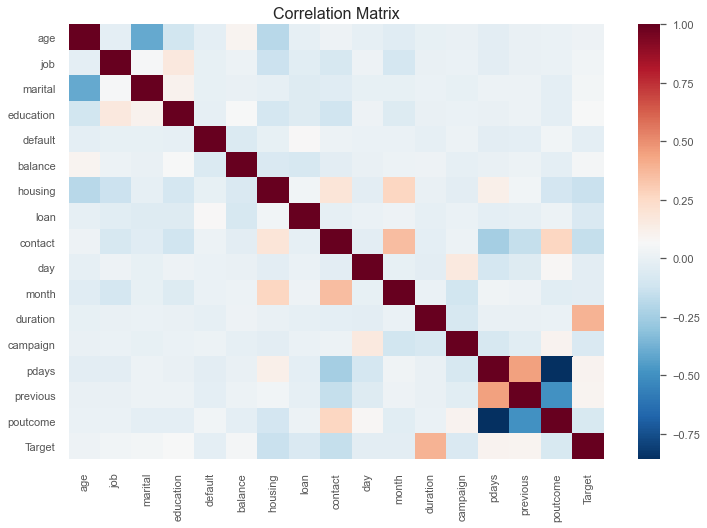

In [274]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
fig = plt.figure(figsize=(12,8))
df_model['Target'] = LabelEncoder().fit_transform(df_model['Target'])

numeric_df = df_model.select_dtypes(exclude="object")

corr_numeric = numeric_df.corr()

sns.heatmap(corr_numeric, cbar=True, cmap="RdBu_r")
plt.title("Correlation Matrix", fontsize=16)
plt.show()

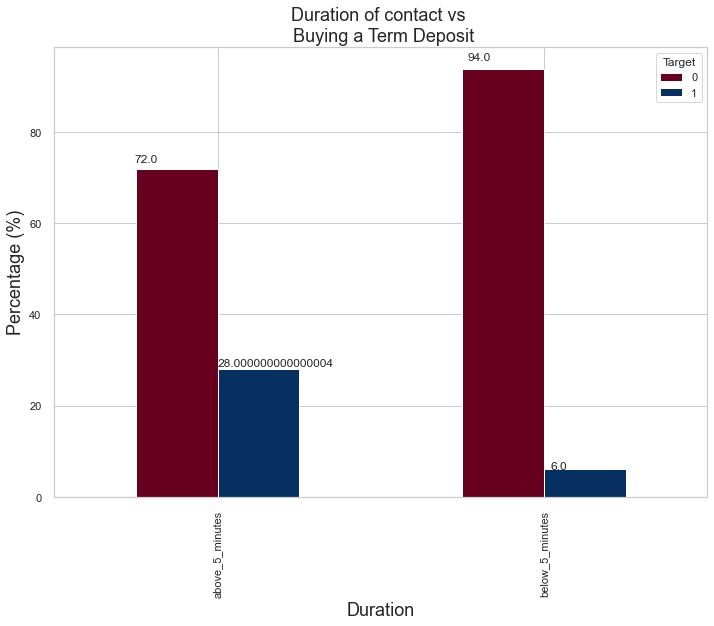

In [275]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style('whitegrid')
five_minutes = 300

lst = [df_model]
df_model["duration_status"] = np.nan

for col in lst:
    col.loc[col["duration"] < five_minutes, "duration_status"] = "below_5_minutes"
    col.loc[col["duration"] >= five_minutes, "duration_status"] = "above_5_minutes"
    
pct_term = pd.crosstab(df_model['duration_status'], df_model['Target']).apply(lambda r: round(r/r.sum(), 2) * 100, axis=1)


ax = pct_term.plot(kind='bar', stacked=False, cmap='RdBu')
plt.title("Duration of contact vs \n Buying a Term Deposit", fontsize=18)
plt.xlabel("Duration", fontsize=18);
plt.ylabel("Percentage (%)", fontsize=18)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.02))
    

plt.show()

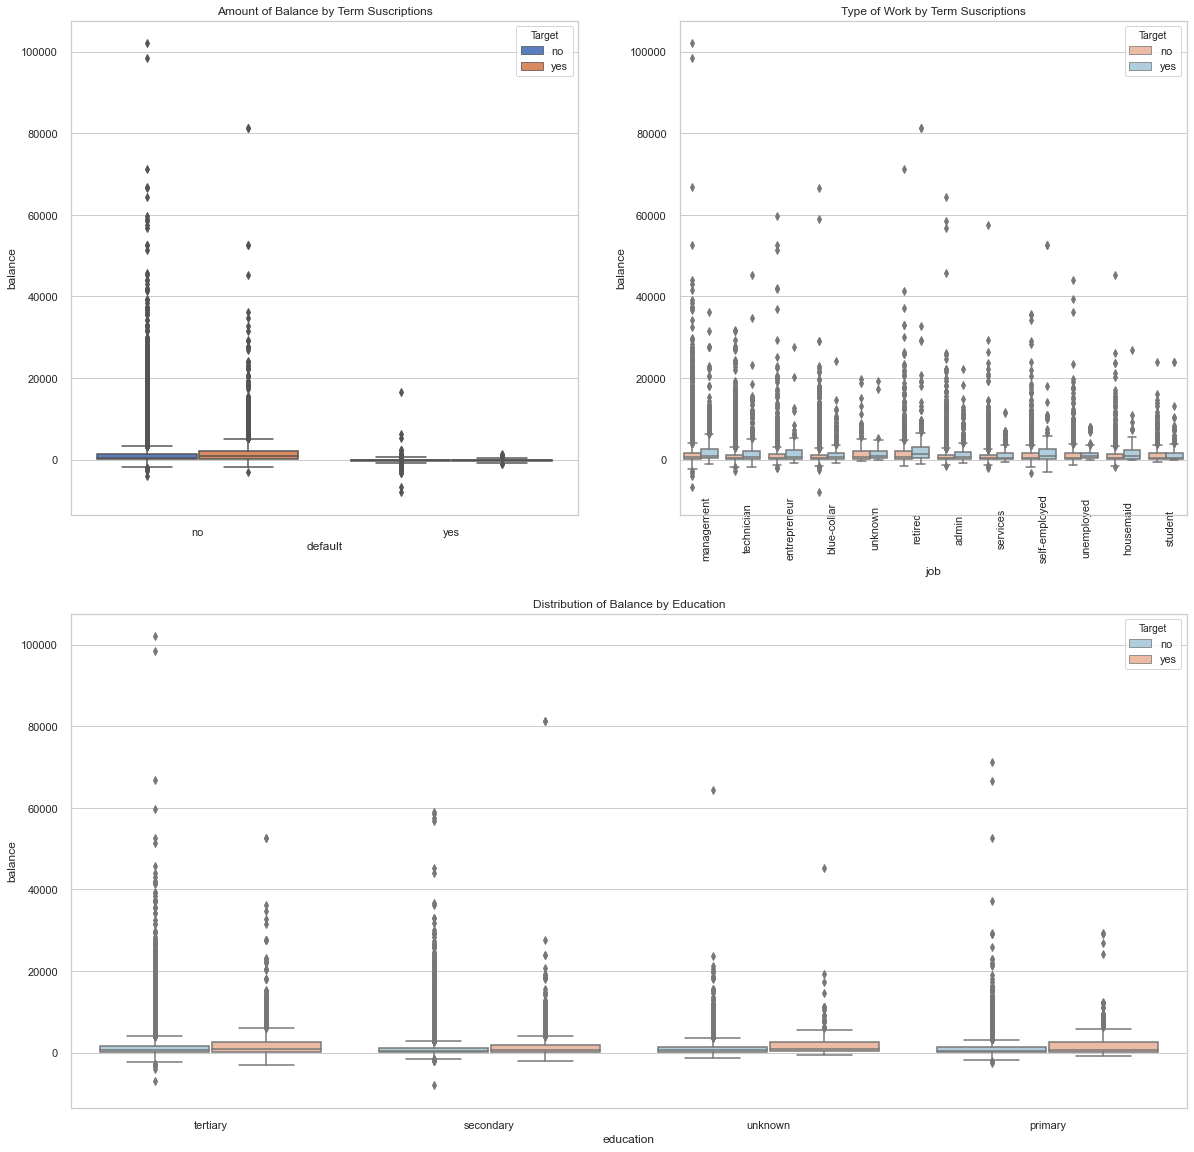

In [276]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

g = sns.boxplot(x="default", y="balance", hue="Target",
                    data=df, palette="muted", ax=ax1)

g.set_title("Amount of Balance by Term Suscriptions")



g1 = sns.boxplot(x="job", y="balance", hue="Target",
                 data=df, palette="RdBu", ax=ax2)

g1.set_xticklabels(df["job"].unique(), rotation=90, rotation_mode="anchor")
g1.set_title("Type of Work by Term Suscriptions")

g2 = sns.boxplot(data=df, x="education", y="balance", hue="Target", palette="RdBu_r")

g2.set_title("Distribution of Balance by Education")


plt.show()

### 28% of the group that is above 5 minutes in conversation with bank in duration opened term deposits while
### those that were below 5 minutese 6%opened term deposit accounts. Campaign should focus on clients whose
### contact duration is above 5 minutes to ncrease deposit subscription

## Deliverable – 2 (Prepare the data for analytics)
### already converted categorical and booleans to category type
### also do standardization

In [277]:
df_model.drop('duration_status', axis=1, inplace=True)

In [278]:
X = df_model.drop('Target',axis=1)
Y = df_model['Target']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30,random_state=1)

In [279]:
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,3
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,3
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,3
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,-1,0,3
4,33,11,2,3,0,1,0,0,2,5,8,198,1,-1,0,3


In [280]:
col_names=df_model.columns
scaler=preprocessing.StandardScaler()
scaled_X_train=scaler.fit_transform(X_train)
scaled_X_test=scaler.fit_transform(X_test)

## Deliverable – 3 (create the ensemble model) – (30)

### Logistc Regression

In [281]:
logreg = LogisticRegression()
logreg.fit(scaled_X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [282]:
y_predict=logreg.predict(scaled_X_test)

In [283]:
def draw_cm( actual, predicted ):
    cm = confusion_matrix( actual, predicted)
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = [0,1] , yticklabels = [0,1] )
    plt.ylabel('Observed')
    plt.xlabel('Predicted')
    plt.show()

Trainig accuracy 0.8910797231965115

Testing accuracy 0.8910350928929519

Confusion Matrix


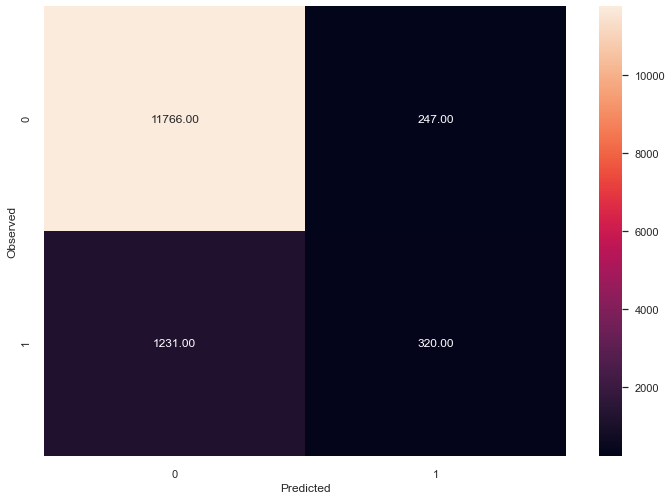

None

Recall: 0.2063185041908446

Precision: 0.564373897707231

F1 Score: 0.3021718602455146

Roc Auc Score: 0.5928787226689677


In [284]:
print("Trainig accuracy",logreg.score(scaled_X_train,y_train))  
print()
print("Testing accuracy",logreg.score(scaled_X_test, y_test))
print()
print('Confusion Matrix')
print(draw_cm(y_test,y_predict))
print()
print("Recall:",recall_score(y_test,y_predict))
print()
print("Precision:",precision_score(y_test,y_predict))
print()
print("F1 Score:",f1_score(y_test,y_predict))
print()
print("Roc Auc Score:",roc_auc_score(y_test,y_predict))


### Decision Tree

In [285]:
model_entropy=DecisionTreeClassifier(criterion='entropy')

In [290]:
model_entropy.fit(scaled_X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [291]:
model_entropy.score(scaled_X_train, y_train)

1.0

In [292]:
model_entropy.score(scaled_X_test, y_test)

0.8770274255381894

In [293]:
clf_pruned = DecisionTreeClassifier(criterion = "entropy", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clf_pruned.fit(scaled_X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=100, splitter='best')

In [294]:
preds_pruned = clf_pruned.predict(scaled_X_test)
preds_pruned_train = clf_pruned.predict(scaled_X_train)

In [295]:
print(accuracy_score(y_test,preds_pruned))
print(accuracy_score(y_train,preds_pruned_train))

0.8897080507225007
0.889120611748349


In [296]:
acc_DT = accuracy_score(y_test, preds_pruned)

In [297]:
df_model.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,3,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,3,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,3,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,-1,0,3,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,-1,0,3,0


In [298]:
xvar = df_model.drop('Target', axis = 1)
feature_cols = xvar.columns

In [302]:
feat_importance = clf_pruned.tree_.compute_feature_importances(normalize=False)
feat_imp_dict = dict(zip(feature_cols, clf_pruned.feature_importances_))
feat_imp = pd.DataFrame.from_dict(feat_imp_dict, orient='index')
feat_imp.sort_values(by=0, ascending=False)

,0
duration,0.82
contact,0.18
age,0.00
job,0.00
marital,0.00
education,0.00
default,0.00
balance,0.00
housing,0.00
loan,0.00


### We can conclude that duration, contact are the variables that influence clients
### subscribing to Term Deposit.  Campaign should focus to improve the subscription

In [303]:
resultsLogRegress = pd.DataFrame({'Method':['Logistics Regression'], 'accuracy': logreg.score(scaled_X_train,y_train)})

In [308]:
resultsLogRegress

,Method,accuracy
0,Logistics Regression,0.89


In [309]:
resultsDTree = pd.DataFrame({'Method':['Decision Tree'], 'accuracy': acc_DT})

In [310]:
resultsDTree

,Method,accuracy
0,Decision Tree,0.89


### Random Forest

In [311]:
from sklearn.ensemble import RandomForestClassifier
rfcl = RandomForestClassifier(n_estimators = 50)
rfcl = rfcl.fit(scaled_X_train, y_train)

In [312]:
pred_RF = rfcl.predict(scaled_X_test)
acc_RF = accuracy_score(y_test, pred_RF)

In [313]:
resultsRF = pd.DataFrame({'Method':['Random Forest'], 'accuracy': [acc_RF]})
resultsRF

,Method,accuracy
0,Random Forest,0.91


### Bagging Classifier Algorithm

In [314]:
from sklearn.ensemble import BaggingClassifier

bgcl = BaggingClassifier(n_estimators=50, max_samples= .7, bootstrap=True, oob_score=True, random_state=22)
bgcl = bgcl.fit(scaled_X_train, y_train)

In [315]:
pred_BG = bgcl.predict(scaled_X_test)
acc_BG = accuracy_score(y_test, pred_BG)

In [316]:
resultsBG = pd.DataFrame({'Method':['Bagging'], 'accuracy': [acc_BG]})
resultsBG

,Method,accuracy
0,Bagging,0.90


### Adaboost Ensemble Algorithm

In [317]:
from sklearn.ensemble import AdaBoostClassifier

abcl = AdaBoostClassifier(n_estimators = 100, learning_rate=0.1, random_state=22)
abcl = abcl.fit(scaled_X_train, y_train)

In [318]:
pred_AB =abcl.predict(scaled_X_test)
acc_AB = accuracy_score(y_test, pred_AB)

In [319]:
resultsAB = pd.DataFrame({'Method':['Adaboost'], 'accuracy': [acc_BG]})

### GradientBoost Classifier Algorithm

In [320]:
from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.1, random_state=22)
gbcl = gbcl.fit(scaled_X_train, y_train)

In [321]:
pred_GB = gbcl.predict(scaled_X_test)
acc_GB = accuracy_score(y_test, pred_GB)

In [322]:
resultsGB = pd.DataFrame({'Method':['Gradient Boost'], 'accuracy': [acc_GB]})
resultsGB

,Method,accuracy
0,Gradient Boost,0.90


In [323]:
resultsLogRegress

,Method,accuracy
0,Logistics Regression,0.89


In [324]:
resultsDTree

,Method,accuracy
0,Decision Tree,0.89


In [325]:
resultsRF

,Method,accuracy
0,Random Forest,0.91


In [326]:
resultsBG

,Method,accuracy
0,Bagging,0.90


In [327]:
resultsAB

,Method,accuracy
0,Adaboost,0.90


In [328]:
resultsGB

,Method,accuracy
0,Gradient Boost,0.90


## Make a DataFrame to compare models and their metrics. Give conclusion regarding 
## the best algorithm and your reason behind it. 


### All models are relatively have similar metrics, Ensemble models perform slightly better than LogRe, and DR